In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [5]:
device

'cuda'

In [8]:
val_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
validation_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=val_transform
)

100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


In [9]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [11]:
data_iter = iter(train_dataloader)

In [12]:
imgs, labels = next(data_iter)

In [13]:
labels

tensor([7, 7, 0, 6, 4, 0, 5, 4, 1, 0, 7, 8, 5, 1, 7, 3, 2, 0, 2, 4, 5, 5, 4, 7,
        0, 2, 1, 2, 6, 0, 2, 8])

In [14]:
imgs.size()

torch.Size([32, 3, 32, 32])

In [15]:
img = imgs[0]

In [16]:
img_permute = img.permute(1, 2, 0)

In [17]:
img_permute = 0.5 * img_permute + 0.5

In [18]:
img_permute = np.clip(img_permute, 0, 1)

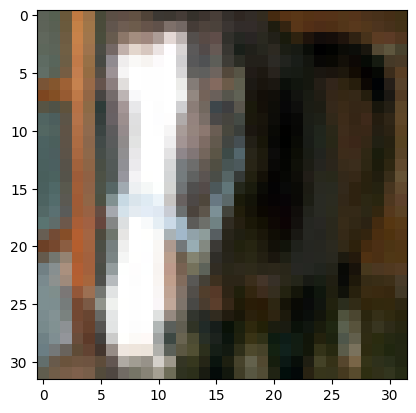

In [19]:
plt.imshow(img_permute)

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [21]:
model = CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [23]:
num_epochs = 15

losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    #
    # validation loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print(
        "epoch: {}, loss: {}, acc:{}, \
  val loss: {}, val acc: {}".format(
            epoch, running_loss, running_acc, val_running_loss, val_running_acc
        )
    )

epoch: 0, loss: 1.4200651537357656, acc:0.4830254316329956,   val loss: 1.1450168983624005, val acc: 0.5891573429107666
epoch: 1, loss: 1.0208911555589808, acc:0.6377559304237366,   val loss: 0.9198166118643154, val acc: 0.6733226776123047
epoch: 2, loss: 0.868985578045964, acc:0.6941378712654114,   val loss: 0.8020314920824557, val acc: 0.723542332649231
epoch: 3, loss: 0.7838585262335194, acc:0.7267074584960938,   val loss: 0.7313217890148346, val acc: 0.747404158115387
epoch: 4, loss: 0.7240187431556325, acc:0.7475607991218567,   val loss: 0.7177668614699818, val acc: 0.7507987022399902
epoch: 5, loss: 0.682819876774564, acc:0.7641754746437073,   val loss: 0.7119896776569538, val acc: 0.7486022114753723
epoch: 6, loss: 0.6544304238209264, acc:0.7720929384231567,   val loss: 0.6947878189741994, val acc: 0.7549920082092285
epoch: 7, loss: 0.6294800205750871, acc:0.7818498015403748,   val loss: 0.64784766043337, val acc: 0.7790535092353821
epoch: 8, loss: 0.6102444946060407, acc:0.7868

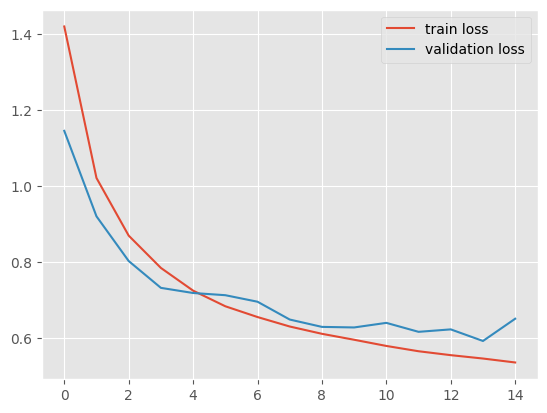

In [24]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

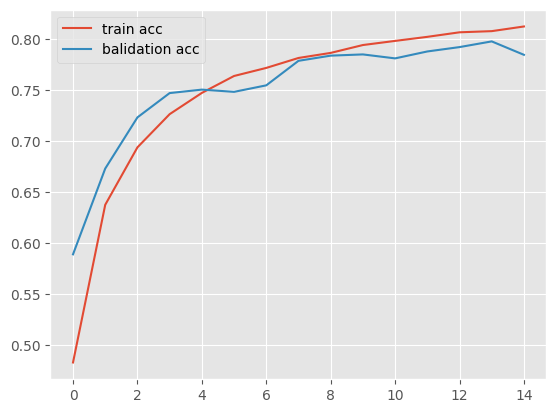

In [26]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="balidation acc")
plt.legend()